In [103]:
import json
from collections import defaultdict
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import cv2
import tqdm
from PIL import Image
import PIL

In [3]:
!pwd

/Users/dmitry/projects/edu/aimasters/2025/research/gaze_detection/eda


In [4]:
import os

In [5]:
# os.chdir(Path(os.getcwd()).resolve().parent)
#!pwd

In [6]:
DATA_ROOT = Path('../data')

In [7]:
gazet_dataset_path = DATA_ROOT / 'GazeT/dataset'
images_path = gazet_dataset_path / 'images'
metadata_path = gazet_dataset_path / 'metadata.json'

In [8]:
metadata = []
with open(metadata_path, 'r') as f:
    metadata = json.load(f)
len(metadata)

144275

In [9]:
train_metadata = [md for md in metadata if md['split'] == 'train']
test_metadata = [md for md in metadata if md['split'] == 'test']
print(f'train: {len(train_metadata)} samples; val: {len(test_metadata)} samples')
print(f'total: {len(train_metadata) + len(test_metadata)}')

train: 118123 samples; val: 26152 samples
total: 144275


In [10]:
train_ids = set()
test_ids = set()
all_ids = set()
for md in metadata:
    all_ids.add(md['task_id'])
    if md['split'] == 'train':
        train_ids.add(md['task_id'])
    if md['split'] == 'test':
        test_ids.add(md['task_id'])
len(train_ids), len(test_ids), len(all_ids)

(5583, 1161, 6744)

In [11]:
stats = {'train': defaultdict(lambda :defaultdict(int)),
         'test': defaultdict(lambda :defaultdict(int))}
count = defaultdict(int)

In [12]:
for md in metadata:
    stats[md['split']]['type'][md['type']] += 1

In [13]:
stats

{'train': defaultdict(<function __main__.<lambda>()>,
             {'type': defaultdict(int,
                          {'gaze_on_fixed_point': 12882,
                           'gaze_on_random_point': 105241})}),
 'test': defaultdict(<function __main__.<lambda>()>,
             {'type': defaultdict(int,
                          {'gaze_on_fixed_point': 10697,
                           'gaze_on_random_point': 15455})})}

Распределение расстояний в пикселах между краями левого и правого глаз

28 496
36 440
247


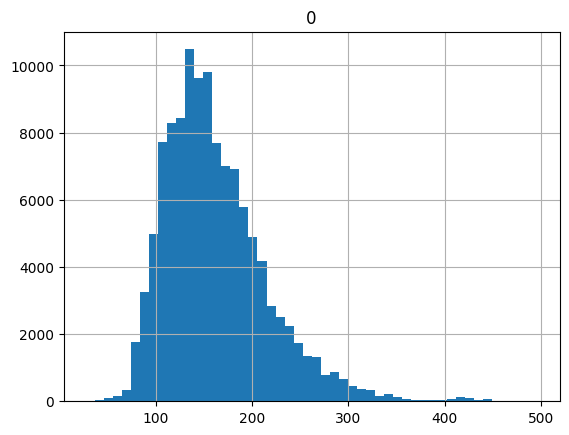

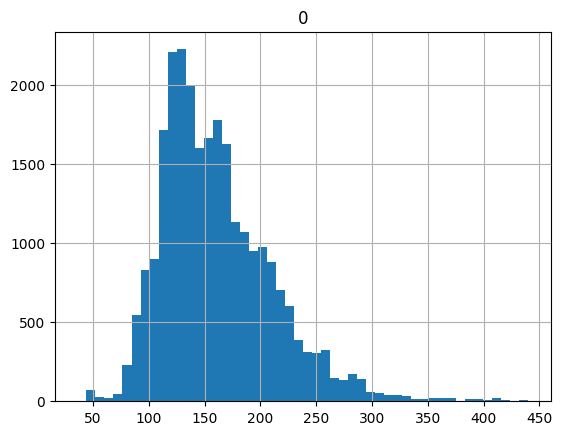

In [14]:
err_ell = {'train': [], 'test': []}
pick = []
for md in metadata:
    diff_x = -(md['eyes_right_right'][0] - md['eyes_left_left'][0])
    diff_y = -(md['eyes_right_right'][1] - md['eyes_left_left'][1])
    # if abs(diff_y) > 60:
    #     pick.append(md)
    # if diff_x < 60:
    #     pick.append(md)
    err_ell[md['split']].append(diff_x)

err_ell_train_df = pd.DataFrame(err_ell['train'])
err_ell_train_df.hist(bins=50)
print(err_ell_train_df.min().item(), err_ell_train_df.max().item())
err_ell_test_df = pd.DataFrame(err_ell['test'])
err_ell_test_df.hist(bins=50)
print(err_ell_test_df.min().item(), err_ell_test_df.max().item())
print(len(pick))

In [15]:
it = iter(pick)

../data/GazeT/dataset/images/7f3976f3-27bc-4993-9898-aab9a4d05d3d/step_6.jpeg
28 7


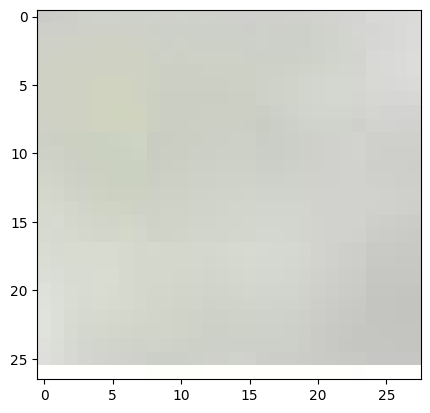

In [16]:
p = next(it)
print(str(images_path / p['task_id'] / p['step']))
# plt.imshow(Image.open(str(images_path / p['task_id'] / p['step'])))
err = p['eyes_right_right']
ell = p['eyes_left_left']
print(ell[0] - err[0], abs(ell[1] - err[1]))
imshow = plt.imshow(255 - cv2.imread(str(images_path / p['task_id'] / p['step']))[min(err[1], ell[1]) - 10:max(err[1], ell[1]) + 10, err[0]:ell[0]])
imshow

Распределение кропов

In [93]:
def crop_img(src, md):
    x, y = md['eyes_right_right']
    x_vals = np.nonzero(src[y, :])[0]
    l, r = x_vals[0], x_vals[-1]
    y_vals = np.nonzero(src[:, x])[0]
    t, b = y_vals[0], y_vals[-1]
    return l, t, r, b

def crop(md):
    im = cv2.imread(str(images_path / md['task_id'] / md['step']))
    l, t, r, b = crop_img(im, md)
    return 255 - im[t:b, l:r]

In [94]:
it = iter(train_metadata)
grid_w = 3
grid_h = 2
batch_size = grid_w * grid_h

In [108]:
crop_stats = defaultdict(lambda: defaultdict(list))
errors = []
for md in tqdm.tqdm(metadata):
    try:
        crop_shape = crop(md).shape
        crop_stats[md['split']]['height'].append(crop_shape[0])
        crop_stats[md['split']]['width'].append(crop_shape[1])
    except IndexError:
        errors.append(md)

len(errors)

100%|██████████| 144275/144275 [03:53<00:00, 618.13it/s]


In [168]:
for i, err in enumerate(errors):
    print(i, f'{err["task_id"]}/{err["step"]}')
    cv2.imshow(f'im_{i}', cv2.imread(str(images_path / err['task_id'] / err['step'])))
    cv2.waitKey(1)

0 49f0232b-771a-4a24-9e5a-5647db0cbfab/step_38.jpeg
1 49f0232b-771a-4a24-9e5a-5647db0cbfab/step_39.jpeg


In [114]:
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

array([[<Axes: title={'center': 'height'}>,
        <Axes: title={'center': 'width'}>]], dtype=object)

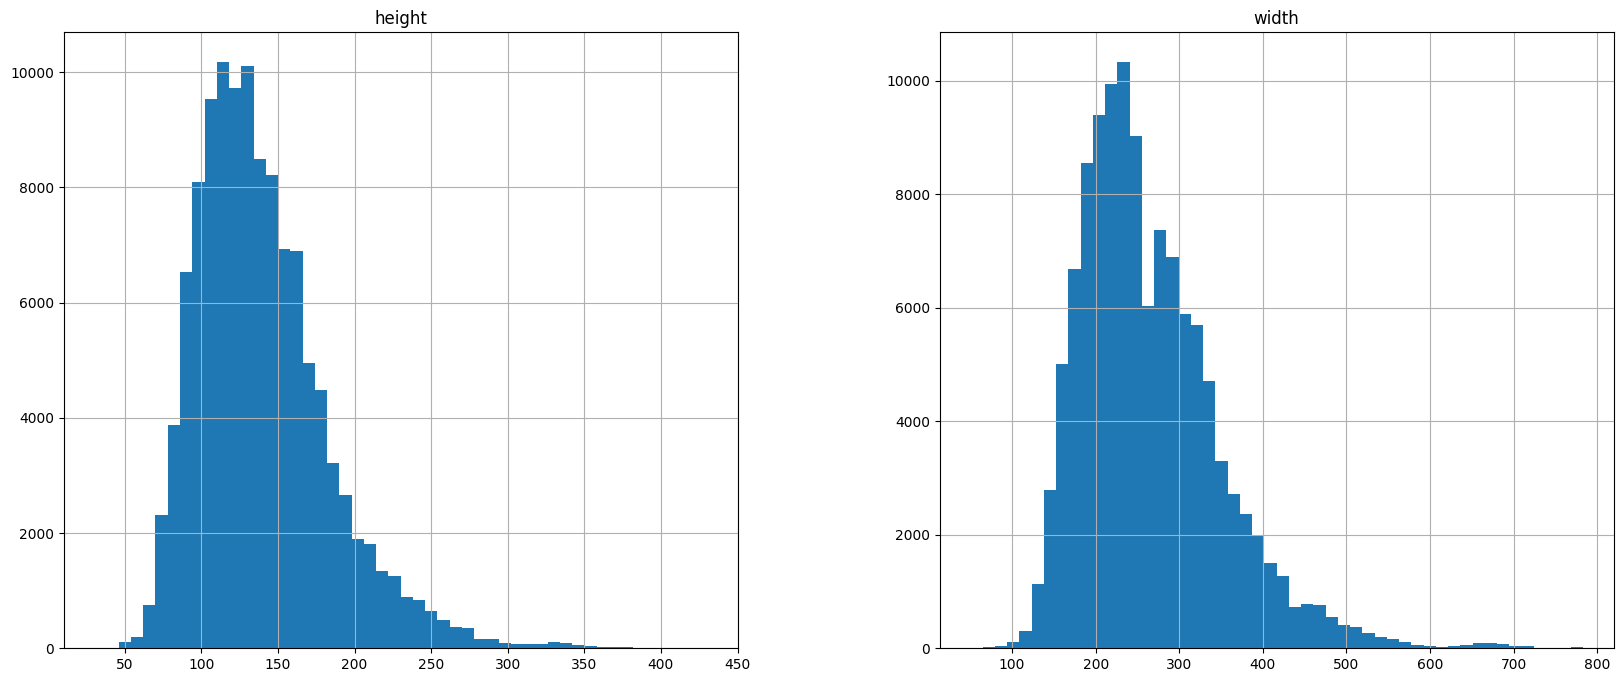

In [120]:
pd.DataFrame(crop_stats['train']).hist(bins=50, figsize=(20, 8))

array([[<Axes: title={'center': 'height'}>,
        <Axes: title={'center': 'width'}>]], dtype=object)

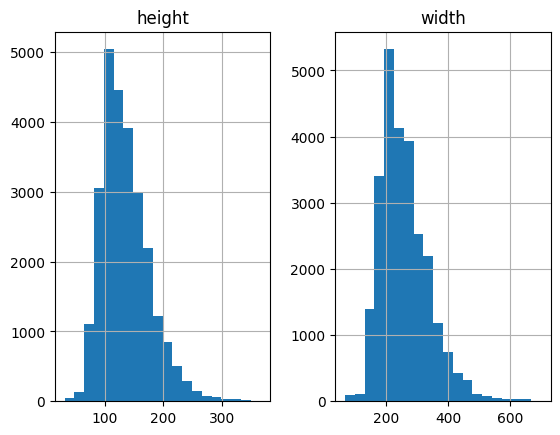

In [118]:
pd.DataFrame(crop_stats['test']).hist(bins=20)

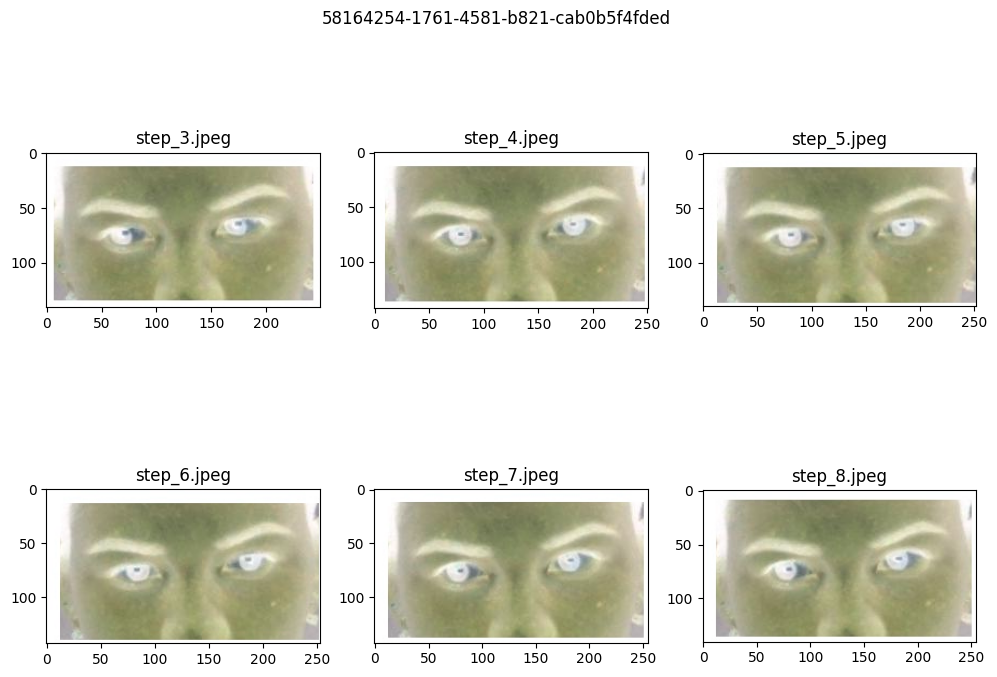

In [98]:
%matplotlib inline
fig, axs = plt.subplots(grid_h, grid_w, figsize=(12, 8))
for i in range(grid_h):
    for j in range(grid_w):
        md = next(it)
        ax = axs[i, j]
        im = crop(md)
        ax.imshow(im)
        ax.set_title(md['step'])
plt.suptitle(md['task_id'])
plt.show()

Артефакты по краям вероятно связаны с jpeg сжатием

In [ ]:
crop_stats = {}
for tmd in train_metadata:
    crop =

In [30]:
with open(metadata_path, 'r') as f:
    metadata = json.load(f)
    metadata_df = pd.DataFrame(metadata)
metadata_df

,task_id,step,relative_x,relative_y,screen_size_x,screen_size_y,screen_size_cm_x,screen_size_cm_y,diagonal_cm,type,is_notebook,eyes_left_left,eyes_left_right,eyes_right_left,eyes_right_right,split
0,8f0ba296-96d9-4ff0-8de9-13cc0e2ae671,step_0.jpeg,0.00,0.000,1280,1024,33.731190,26.984952,43.197,gaze_on_fixed_point,False,"[632, 688]","[543, 698]","[434, 711]","[347, 722]",train
1,8f0ba296-96d9-4ff0-8de9-13cc0e2ae671,step_1.jpeg,1.00,0.000,1280,1024,33.731190,26.984952,43.197,gaze_on_fixed_point,False,"[574, 679]","[494, 684]","[395, 692]","[332, 699]",train
2,8f0ba296-96d9-4ff0-8de9-13cc0e2ae671,step_2.jpeg,0.00,1.000,1280,1024,33.731190,26.984952,43.197,gaze_on_fixed_point,False,"[669, 724]","[582, 733]","[475, 741]","[390, 746]",train
3,8f0ba296-96d9-4ff0-8de9-13cc0e2ae671,step_3.jpeg,1.00,1.000,1280,1024,33.731190,26.984952,43.197,gaze_on_fixed_point,False,"[592, 731]","[511, 739]","[416, 745]","[352, 747]",train
4,8f0ba296-96d9-4ff0-8de9-13cc0e2ae671,step_4.jpeg,0.50,0.500,1280,1024,33.731190,26.984952,43.197,gaze_on_fixed_point,False,"[622, 703]","[542, 711]","[444, 720]","[377, 728]",train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144270,192e5981-e72c-4151-8622-a29e95690e7d,step_51.jpeg,0.20,0.550,1920,1080,50.937489,28.652338,58.443,gaze_on_random_point,False,"[1028, 643]","[985, 650]","[931, 652]","[889, 649]",test
144271,192e5981-e72c-4151-8622-a29e95690e7d,step_52.jpeg,-0.15,0.550,1920,1080,50.937489,28.652338,58.443,gaze_on_random_point,False,"[1033, 644]","[990, 652]","[936, 654]","[893, 650]",test
144272,192e5981-e72c-4151-8622-a29e95690e7d,step_53.jpeg,0.45,0.550,1920,1080,50.937489,28.652338,58.443,gaze_on_random_point,False,"[1033, 647]","[989, 654]","[935, 657]","[892, 653]",test
144273,192e5981-e72c-4151-8622-a29e95690e7d,step_54.jpeg,0.45,0.175,1920,1080,50.937489,28.652338,58.443,gaze_on_random_point,False,"[1034, 641]","[990, 649]","[935, 651]","[891, 649]",test


In [32]:
# metadata_df.to_csv(DATA_ROOT / 'processed' / 'GazeT' / 'metadata.csv', index=False)

In [121]:
def create_not_set():

NOT_SET = object()

In [157]:
def next(iterator, default=NOT_SET):
    try:
        return iterator.__next__()
    except StopIteration:
        if default is not NOT_SET:
            return default
        raise
        return None

In [165]:
b = [1, 2]

In [166]:
it = iter(b)

In [167]:
a = next(it, None)
while a is not None:
    print(a)
    a = next(it, None)

1
2
